### Are we moving towards a more environmentally favourable diet?
Use different time series algorithms with Python to build a model than can forecast the animal-based food consumption (per continents) for the next 10/15 years based on the last 53 years (1961 - 2013). Try with differents models : 
1. Exponential Smoothing
2. OLS Model 
3. ARIMA
4. FB Prophete (Facebook)



In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

from plotly import __version__
from plotly.offline import download_plotlyjs,init_notebook_mode,plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected=True)

In [28]:
df=pd.read_csv('food dataset Tableau.csv')
df.head()

,Unnamed: 0,Country Code,Country,Element Code,Element,Item Code,Item,Year,Unit,Value
0,106,5100,Africa,664,Food supply (kcal/capita/day),2731,Bovine Meat,1961,kcal/capita/day,37.0
1,107,5100,Africa,664,Food supply (kcal/capita/day),2731,Bovine Meat,1962,kcal/capita/day,36.0
2,108,5100,Africa,664,Food supply (kcal/capita/day),2731,Bovine Meat,1963,kcal/capita/day,36.0
3,109,5100,Africa,664,Food supply (kcal/capita/day),2731,Bovine Meat,1964,kcal/capita/day,35.0
4,110,5100,Africa,664,Food supply (kcal/capita/day),2731,Bovine Meat,1965,kcal/capita/day,36.0


In [29]:
df.Item.value_counts()

Eggs                       2270
Milk - Excluding Butter    1135
Bovine Meat                1135
Fish, Seafood              1135
Grand Total                1135
Animal Products            1135
Mutton & Goat Meat         1135
Pigmeat                    1135
Crustaceans                1135
Meat                       1135
Honey                      1135
Cheese                     1060
Name: Item, dtype: int64

In [30]:
df_food=df.drop(columns=['Unnamed: 0','Element Code','Element'],axis=1)

## Quick data Description

In [31]:
dfC=df_food.loc[(df_food.Country == 'Africa')|(df_food.Country == 'Asia')|(df_food.Country == 'Oceania')|(df_food.Country == 'Europe')|(df_food.Country == 'Americas')]

dfC=dfC[['Year','Country','Item','Value']]
dfC.head()

,Year,Country,Item,Value
0,1961,Africa,Bovine Meat,37.0
1,1962,Africa,Bovine Meat,36.0
2,1963,Africa,Bovine Meat,36.0
3,1964,Africa,Bovine Meat,35.0
4,1965,Africa,Bovine Meat,36.0


In [32]:
df_per_item=df_food.pivot_table(index=['Country','Item','Year'])
df_per_item.drop(columns=['Country Code','Item Code'],axis=1,inplace=True)
df_per_item.head()

Value
Country Item            Year       
Africa  Animal Products 1961  156.0
                        1962  154.0
                        1963  152.0
                        1964  154.0
                        1965  158.0

In [12]:
def name_plot(Country, Item):
    data = df_per_item.loc[Country, Item]
    return plt.plot(data.index, data.values)

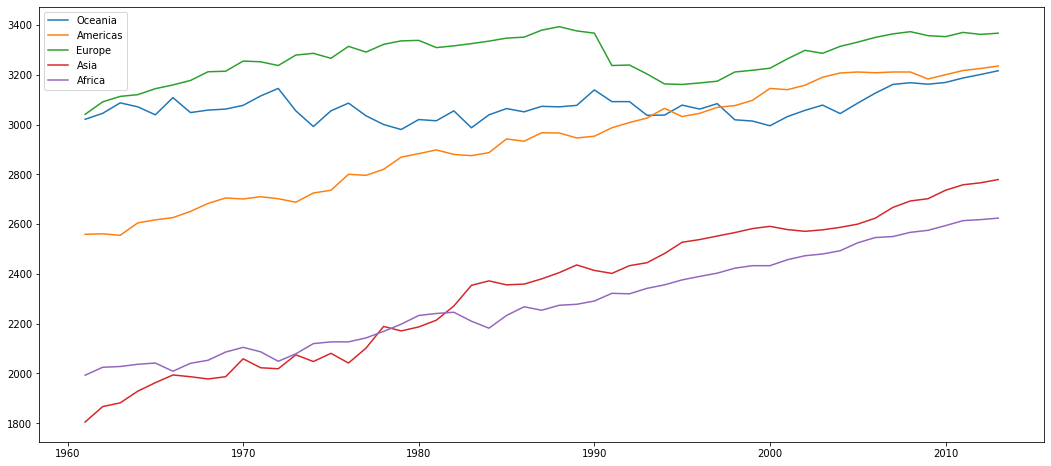

In [13]:
plt.figure(figsize = (18, 8))

continents = ['Oceania','Americas','Europe','Asia','Africa']

for cont in continents:
    name_plot(cont, 'Grand Total')

plt.legend(continents)

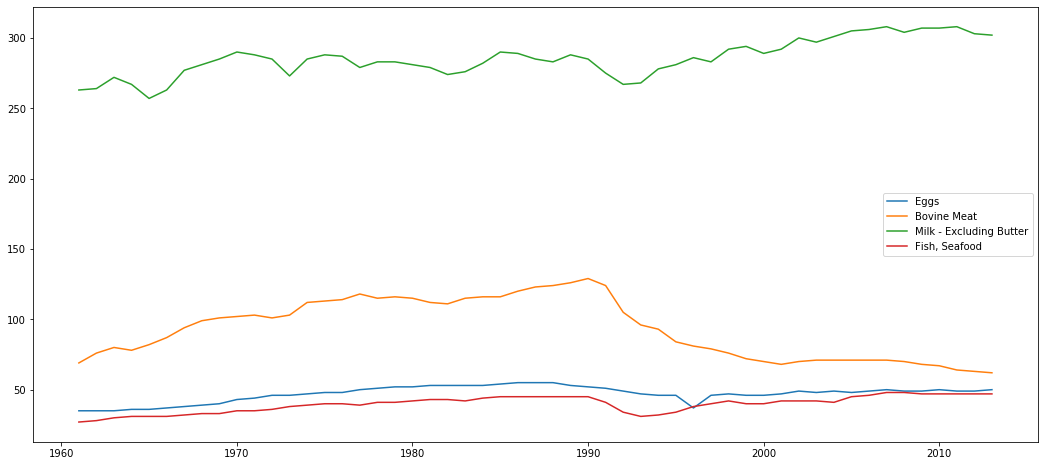

In [14]:
plt.figure(figsize = (18, 8))

items = ['Eggs','Bovine Meat','Milk - Excluding Butter','Fish, Seafood']

for item in items:
    name_plot('Europe',item)

plt.legend(items)

## Time Series Model 
Use different time series algorithms with Python to build a model than can forecast the animal-based food consumption (per continents) for the next 10/15 years based on the last 53 years (1961 - 2013)
Try with differents models
- Exponential Smoothing
- OLS Model 
- ARIMA
- FB Prophete (Facebook)


### Moving Average 

In [33]:
df_Europe=dfC.loc[dfC.Country == 'Europe'].set_index('Year').drop(columns=['Country','Item'],axis=1)
df_Europe.groupby('Year')

In [34]:
df_EU=df_Europe.groupby('Year').mean()

In [35]:
def moving_average(series,n):
    return np.average(series[-n:])

moving_average(df_EU.Value,40)

416.57307692307694

In [36]:
def plotMovingAverage(series, n, plot_bounds=False):
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    rolling_mean = series.rolling(window=n).mean()
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    if plot_bounds:
        rolling_std =  series.rolling(window=n).std()
        upper_bound = rolling_mean+1.96*rolling_std
        lower_bound = rolling_mean-1.96*rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));
    plt.xticks(rotation=45)

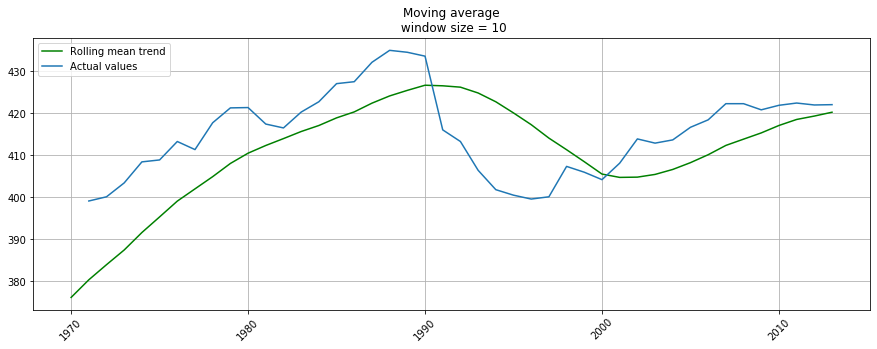

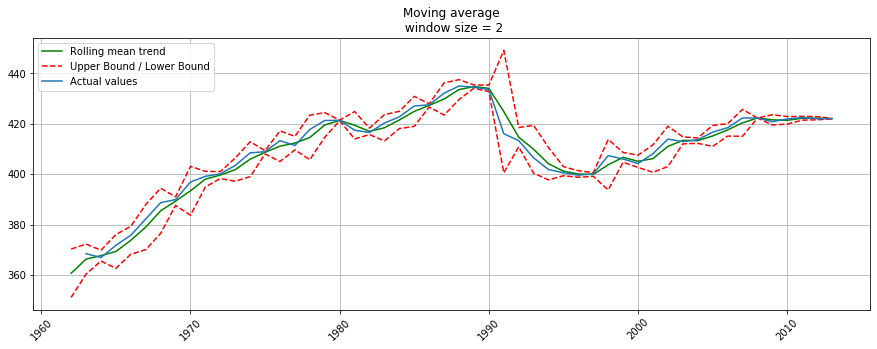

In [37]:
plotMovingAverage(df_EU.Value,10)
plotMovingAverage(df_EU.Value,2,plot_bounds=True)


### Exponential smoothing

In [38]:
def exponential_smoothing(series, alpha):
    result=[series[0]]
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

In [39]:
exponential_smoothing(df_EU.Value.values, 0.01)

[357.2307692307692,
 357.3,
 357.4116153846154,
 357.50673,
 357.6493550076923,
 357.8305537653077,
 358.0745559199623,
 358.38073343768576,
 358.6961568725397,
 359.078426073045,
 359.47918027385305,
 359.885926932653,
 360.32168304794186,
 360.80308160207784,
 361.2842815552878,
 361.80451566281187,
 362.3003166600299,
 362.85500580112193,
 363.43953266618763,
 364.0189834933719,
 364.55340904305353,
 365.0732595680076,
 365.6256038954044,
 366.19704016414266,
 366.80583899327047,
 367.4131652187224,
 368.06057202807364,
 368.7299663077929,
 369.3880512600996,
 370.0303245936524,
 370.4907905784851,
 370.91895959577715,
 371.27438538443477,
 371.580103069052,
 371.8696866537461,
 372.1471436333625,
 372.42721065856733,
 372.7767847058278,
 373.10901685876956,
 373.4202343824896,
 373.76757050020313,
 374.16912556443185,
 374.55666507801834,
 374.94802150416126,
 375.3654643660427,
 375.7964251069977,
 376.2615377790046,
 376.72199932429146,
 377.1632408695101,
 377.61083923004577,
 3

In [40]:
def exponential_smoothing(series, alpha):
#     print(series[0])
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

exponential_smoothing(df_EU.Value.values, 0.01)

[357.2307692307692,
 357.3,
 357.4116153846154,
 357.50673,
 357.6493550076923,
 357.8305537653077,
 358.0745559199623,
 358.38073343768576,
 358.6961568725397,
 359.078426073045,
 359.47918027385305,
 359.885926932653,
 360.32168304794186,
 360.80308160207784,
 361.2842815552878,
 361.80451566281187,
 362.3003166600299,
 362.85500580112193,
 363.43953266618763,
 364.0189834933719,
 364.55340904305353,
 365.0732595680076,
 365.6256038954044,
 366.19704016414266,
 366.80583899327047,
 367.4131652187224,
 368.06057202807364,
 368.7299663077929,
 369.3880512600996,
 370.0303245936524,
 370.4907905784851,
 370.91895959577715,
 371.27438538443477,
 371.580103069052,
 371.8696866537461,
 372.1471436333625,
 372.42721065856733,
 372.7767847058278,
 373.10901685876956,
 373.4202343824896,
 373.76757050020313,
 374.16912556443185,
 374.55666507801834,
 374.94802150416126,
 375.3654643660427,
 375.7964251069977,
 376.2615377790046,
 376.72199932429146,
 377.1632408695101,
 377.61083923004577,
 3

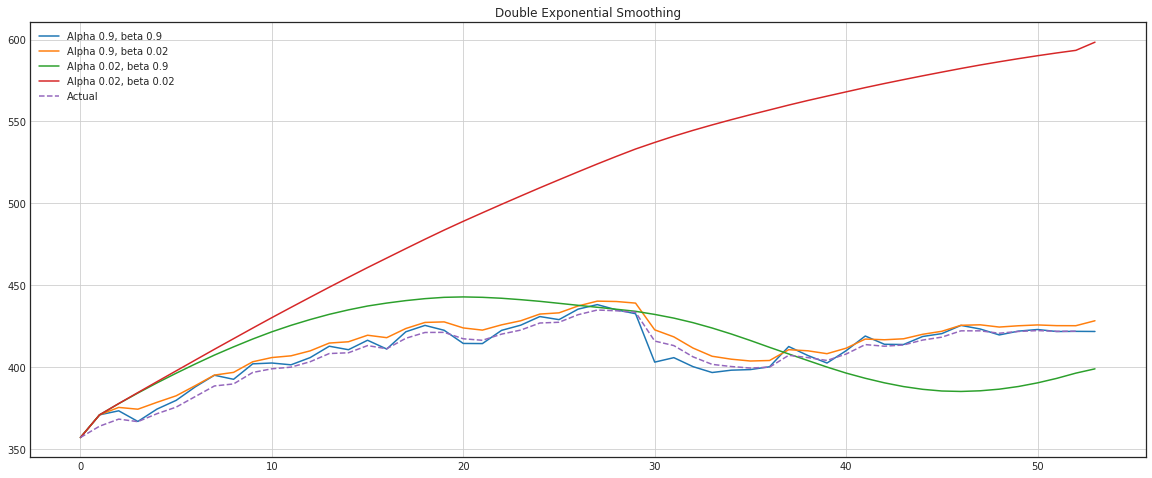

In [41]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): 
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df_EU.Value.values, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df_EU.Value.values, label = "Actual",linestyle='--')
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

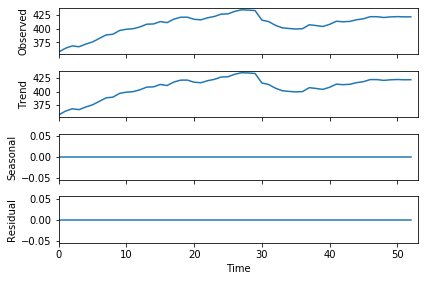

<Figure size 1728x1296 with 0 Axes>

In [42]:
from random import randrange
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = list(df_EU.Value.values)
result = seasonal_decompose(series, model='additive', freq=1)
result.plot()
pyplot.figure(figsize = (24, 18))
pyplot.show()

### Model OLS

In [43]:
df_EU['trend']=df_EU.index-1960

In [53]:
y= result.trend

In [54]:
X =df_EU.trend

In [55]:
from statsmodels.tools.tools import add_constant
mod=sm.OLS(y,add_constant(X)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     35.24
Date:                Sat, 14 Dec 2019   Prob (F-statistic):           2.58e-07
Time:                        16:32:07   Log-Likelihood:                -215.98
No. Observations:                  53   AIC:                             436.0
Df Residuals:                      51   BIC:                             439.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        387.1739      4.046     95.700      0.000     379.052     395.296
trend          0.7740      0.130      5.937      0.000       0.512       1.036
==============================================================================
Omnibus:                        3.294   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                1.734
Skew:                           0.109   Prob(JB):                        0.420
Kurtosis:                       2.141   Cond. No.                         63.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

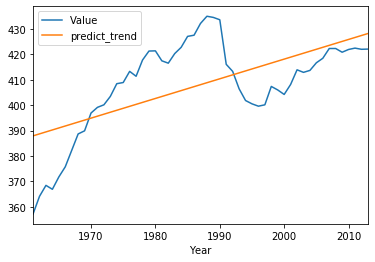

In [56]:
df_EU['predict_trend']=mod.predict()
df_EU.drop('trend',axis=1).plot()

In [57]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        print("Dickey Fuller: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()
    return 

In [61]:
df1=df_EU.drop(columns=['trend','predict_trend'],axis=1)
df2=df1.reset_index()

,Year,Value
0,1961,357.230769
1,1962,364.153846
2,1963,368.461538
3,1964,366.923077
4,1965,371.769231


Dickey Fuller: p=0.153898


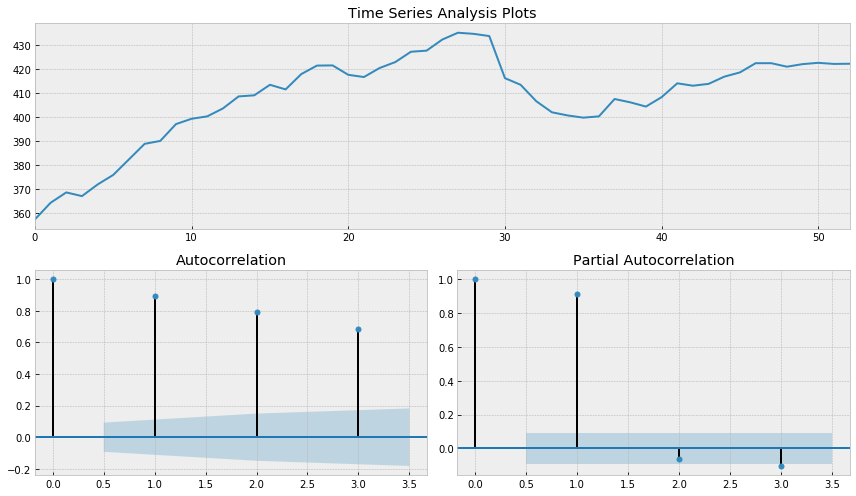

In [63]:
tsplot(df2.Value, lags=3)

### Model Prophete

In [132]:
!pip install fbprophet

In [64]:
from fbprophet import Prophet

model = Prophet(interval_width=0.95)

In [65]:
df1=df_EU.drop(columns=['trend','predict_trend'],axis=1)
df1.reset_index(inplace=True)
df1.head()

,Year,Value
0,1961,357.230769
1,1962,364.153846
2,1963,368.461538
3,1964,366.923077
4,1965,371.769231


In [66]:
df1['Year']=pd.to_datetime(df1['Year'], format='%Y')

In [67]:
df1.rename(columns={'Year':'ds','Value':'y'}, inplace=True)
df1.head()

,ds,y
0,1961-01-01,357.230769
1,1962-01-01,364.153846
2,1963-01-01,368.461538
3,1964-01-01,366.923077
4,1965-01-01,371.769231


In [68]:
model_fit=model.fit(df1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
train = df1.iloc[:39]
test=df1.iloc[38:,:]

In [70]:
# Code for Prophete Model : 

model = Prophet(interval_width=0.95)
model.fit(df1)
future_dates = model.make_future_dataframe(periods=15, freq='y')
forecast = model.predict(future_dates)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
model_fit.predict()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-01-01,-46.488581,352.615395,362.238235,-46.488581,-46.488581,403.794881,403.794881,403.794881,403.794881,403.794881,403.794881,0.0,0.0,0.0,357.306300
1,1962-01-01,-42.513152,358.038731,367.734819,-42.513152,-42.513152,405.449912,405.449912,405.449912,405.449912,405.449912,405.449912,0.0,0.0,0.0,362.936761
2,1963-01-01,-38.537723,362.396790,371.731536,-38.537723,-38.537723,405.667987,405.667987,405.667987,405.667987,405.667987,405.667987,0.0,0.0,0.0,367.130264
3,1964-01-01,-34.562295,365.080760,374.754640,-34.562295,-34.562295,404.458892,404.458892,404.458892,404.458892,404.458892,404.458892,0.0,0.0,0.0,369.896597
4,1965-01-01,-30.575975,368.567917,378.071265,-30.575975,-30.575975,403.794881,403.794881,403.794881,403.794881,403.794881,403.794881,0.0,0.0,0.0,373.218906
5,1966-01-01,-26.600546,374.022312,383.781661,-26.600546,-26.600546,405.449912,405.449912,405.449912,405.449912,405.449912,405.449912,0.0,0.0,0.0,378.849366
6,1967-01-01,-22.625117,378.300379,388.222775,-22.625117,-22.625117,405.667987,405.667987,405.667987,405.667987,405.667987,405.667987,0.0,0.0,0.0,383.042870
7,1968-01-01,-18.649689,381.135957,390.783554,-18.649689,-18.649689,404.458892,404.458892,404.458892,404.458892,404.458892,404.458892,0.0,0.0,0.0,385.809203
8,1969-01-01,-14.663484,384.205965,394.139193,-14.663484,-14.663484,403.794881,403.794881,403.794881,403.794881,403.794881,403.794881,0.0,0.0,0.0,389.131396
9,1970-01-01,-10.689424,389.732937,399.625982,-10.689424,-10.689424,405.449912,405.449912,405.449912,405.449912,405.449912,405.449912,0.0,0.0,0.0,394.760488


In [72]:
future_dates = model.make_future_dataframe(periods=10, freq='y')

In [73]:
forecast = model.predict(future_dates)
viz=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

In [74]:
viz.set_index('ds',inplace=True)

In [75]:
viz.tail(10)

,yhat,yhat_lower,yhat_upper
ds,,,
2013-12-31,420.498548,415.348031,425.376886
2014-12-31,416.478004,411.560070,421.856354
2015-12-31,411.092738,404.808765,417.646979
2016-12-31,428.690708,421.370225,436.328873
2017-12-31,426.053934,416.847425,435.983088
2018-12-31,422.033390,409.418098,434.830371
2019-12-31,416.648125,400.911607,431.020427
2020-12-31,434.246094,414.526609,452.037724
2021-12-31,431.609320,407.978932,452.279290


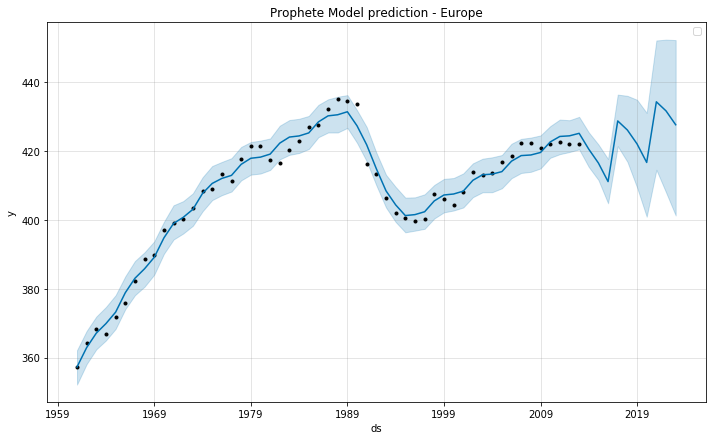

In [76]:
model.plot(forecast,uncertainty=True)
#plt.plot(df_EU.Value.values, label = "Actual",linestyle='--')
plt.legend(loc="best")
plt.axis('tight')
plt.title("Prophete Model prediction - Europe")
plt.grid(True)
plt.show()

In [77]:
df1.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
viz_df = df1.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

Text(0.5, 0, 'Date')

<Figure size 1296x576 with 0 Axes>

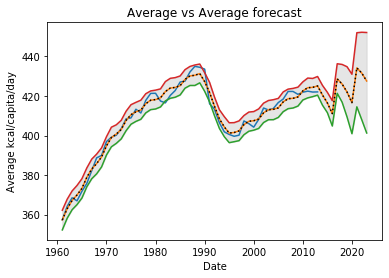

In [78]:
plt.figure(figsize = (18, 8))

fig, ax1 = plt.subplots()
ax1.plot(viz_df)
ax1.plot(viz_df.yhat, color='black', linestyle=':')
ax1.fill_between(viz_df.index, viz_df['yhat_upper'], viz_df['yhat_lower'], alpha=0.3, color='darkgray')
ax1.set_title('Average vs Average forecast')
ax1.set_ylabel('Average kcal/capita/day')
ax1.set_xlabel('Date')

#L=ax1.legend() #get the legend
#L.get_texts()[0].set_text('Actual') #change the legend text for 1st plot
#L.get_texts()[1].set_text('Forecasted') #change the legend text for 2nd plot

### Apply Prophete model with less data

In [79]:
df2=df1[-20:]
df2.reset_index(inplace=True)
df2.head()

,ds,y
0,1994-01-01,401.846154
1,1995-01-01,400.538462
2,1996-01-01,399.615385
3,1997-01-01,400.153846
4,1998-01-01,407.384615


In [80]:
my_model2 = Prophet(interval_width=0.95)

In [81]:
model_fit2=my_model2.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.


In [82]:
future_dates2 = my_model2.make_future_dataframe(periods=10, freq='y')
forecast2 = my_model2.predict(future_dates2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
20,2013-12-31,410.537461,408.265397,412.800782
21,2014-12-31,402.177920,399.741393,404.518697
22,2015-12-31,391.826303,389.128109,394.287600
23,2016-12-31,417.357917,414.314896,420.356389
24,2017-12-31,411.026456,407.218329,414.734917
25,2018-12-31,402.666915,398.260831,406.954646
26,2019-12-31,392.315298,386.592449,397.760074
27,2020-12-31,417.846912,411.556401,424.180904
28,2021-12-31,411.515451,404.193672,418.827807
29,2022-12-31,403.155910,393.950971,411.557069


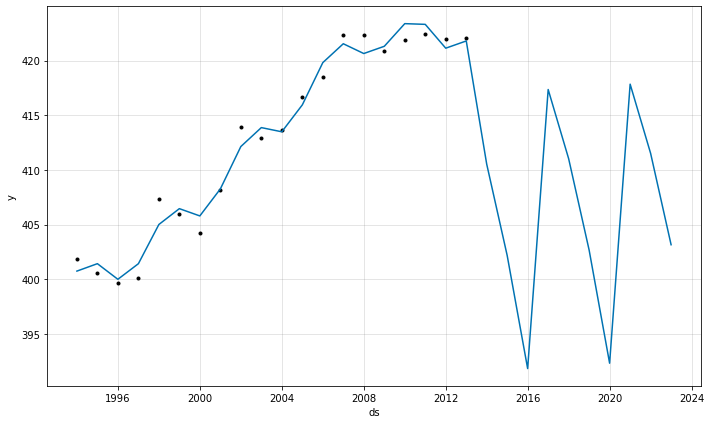

In [83]:
my_model2.plot(forecast2,uncertainty=False)

plt.show()

In [84]:
df2.set_index('ds', inplace=True)
forecast2.set_index('ds', inplace=True)
viz_df2 = df2.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

Text(0.5, 0, 'Date')

<Figure size 1296x576 with 0 Axes>

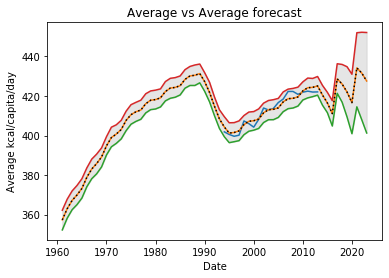

In [85]:
plt.figure(figsize = (18, 8))

fig, ax1 = plt.subplots()
ax1.plot(viz_df2)
ax1.plot(viz_df2.yhat, color='black', linestyle=':')
ax1.fill_between(viz_df2.index, viz_df2['yhat_upper'], viz_df2['yhat_lower'], alpha=0.3, color='darkgray')
ax1.set_title('Average vs Average forecast')
ax1.set_ylabel('Average kcal/capita/day')
ax1.set_xlabel('Date')


### ARIMA
- Seasonality → No
- Auto Regression : Use observations at previous time steps (lags) to predict values at next step (correlation) → p
- Integration : Differencing of time series data required to make data ‘stationary’ → d
- Moving Average : same of AR except for predicting the calculated error → q

- Goal is to obtain optimal value of parameters p,d,q (seasonality, trend and noise)


In [86]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df1.y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.358149
p-value: 0.153898


### Transform type of column Year in datetime

In [87]:
df1.dtypes

y    float64
dtype: object

In [89]:
#df1.drop(columns='index',axis=1,inplace=True)

In [90]:
df1.reset_index(inplace=True)
df1['ds']=pd.to_datetime(df1['ds'], format='%Y')

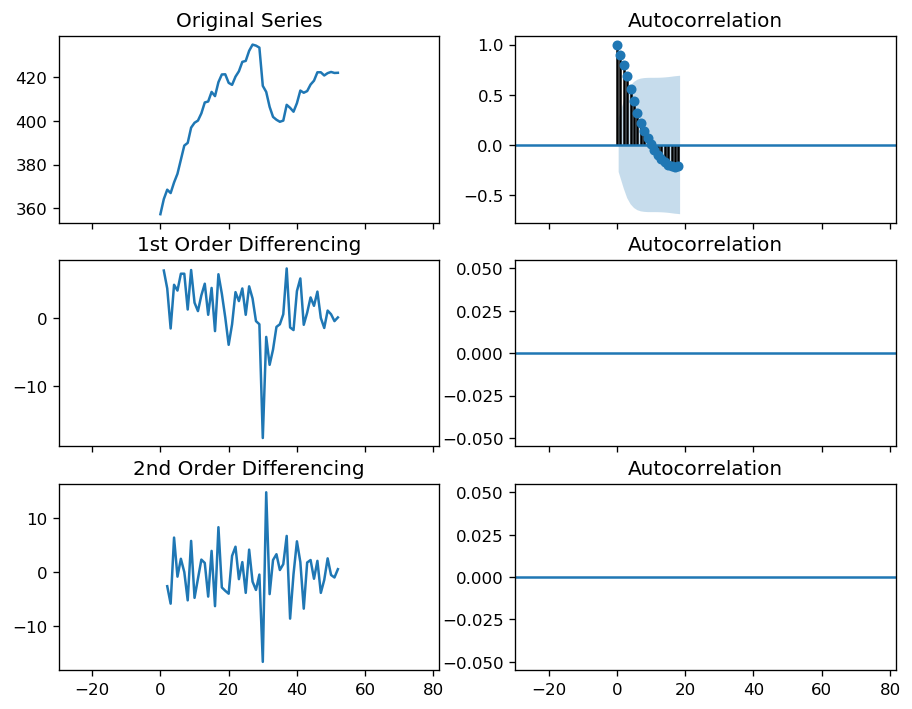

In [91]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df1.y); axes[0, 0].set_title('Original Series')
plot_acf(df1.y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df1.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1.y.diff(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1.y.diff().diff(), ax=axes[2, 1])

plt.show()

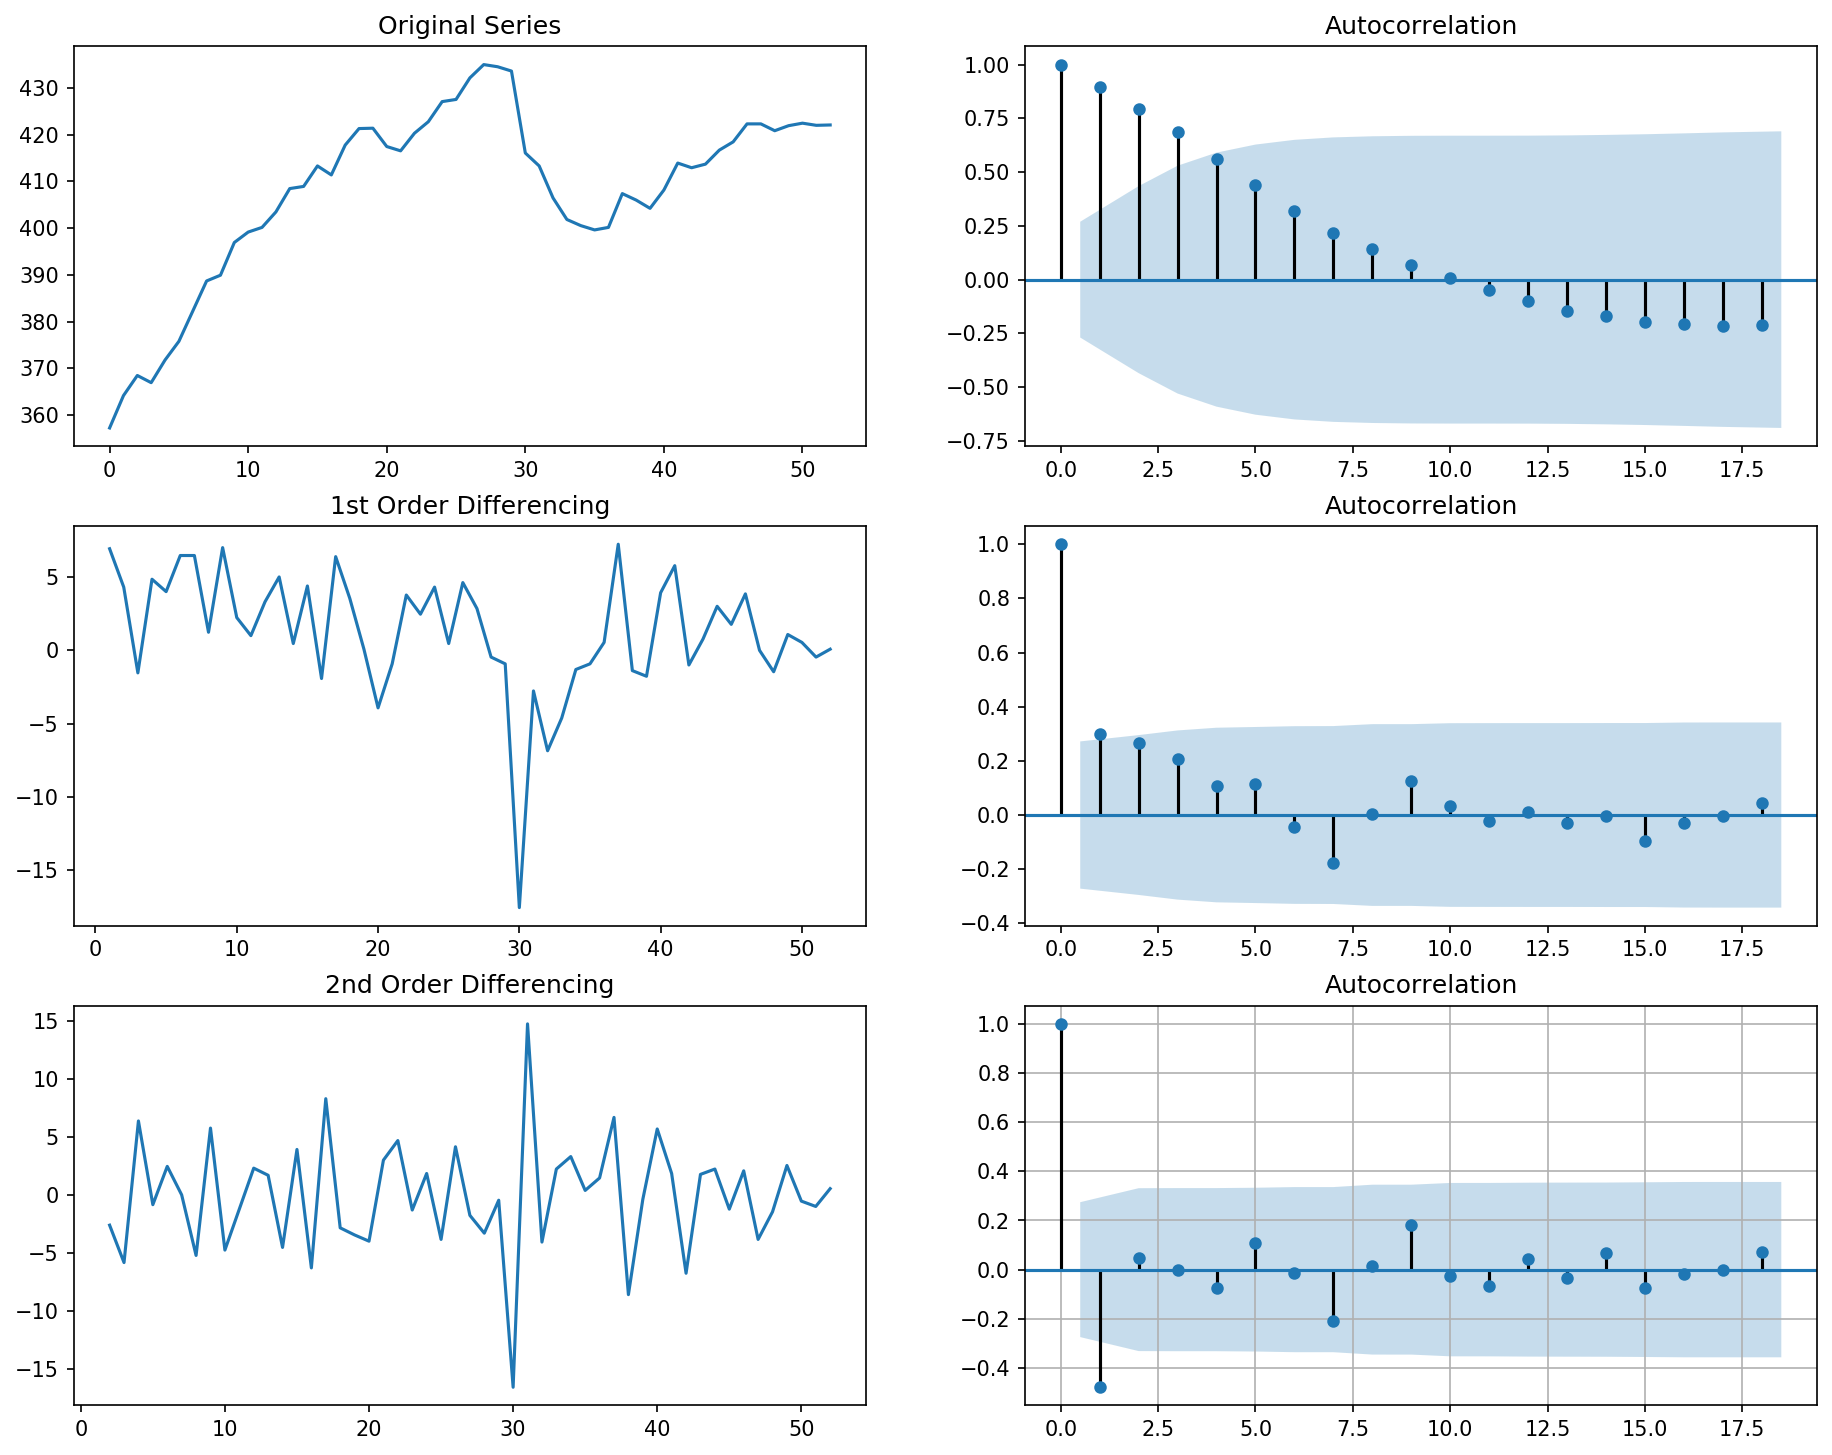

In [92]:
plt.rcParams.update({'figure.figsize':(15,12), 'figure.dpi':150})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df1.y); axes[0, 0].set_title('Original Series')
plot_acf(df1.y, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df1.y.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df1.y.diff()[1:], ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df1.y.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df1.y.diff().diff()[2:], ax=axes[2, 1])
plt.grid(True)
plt.show()

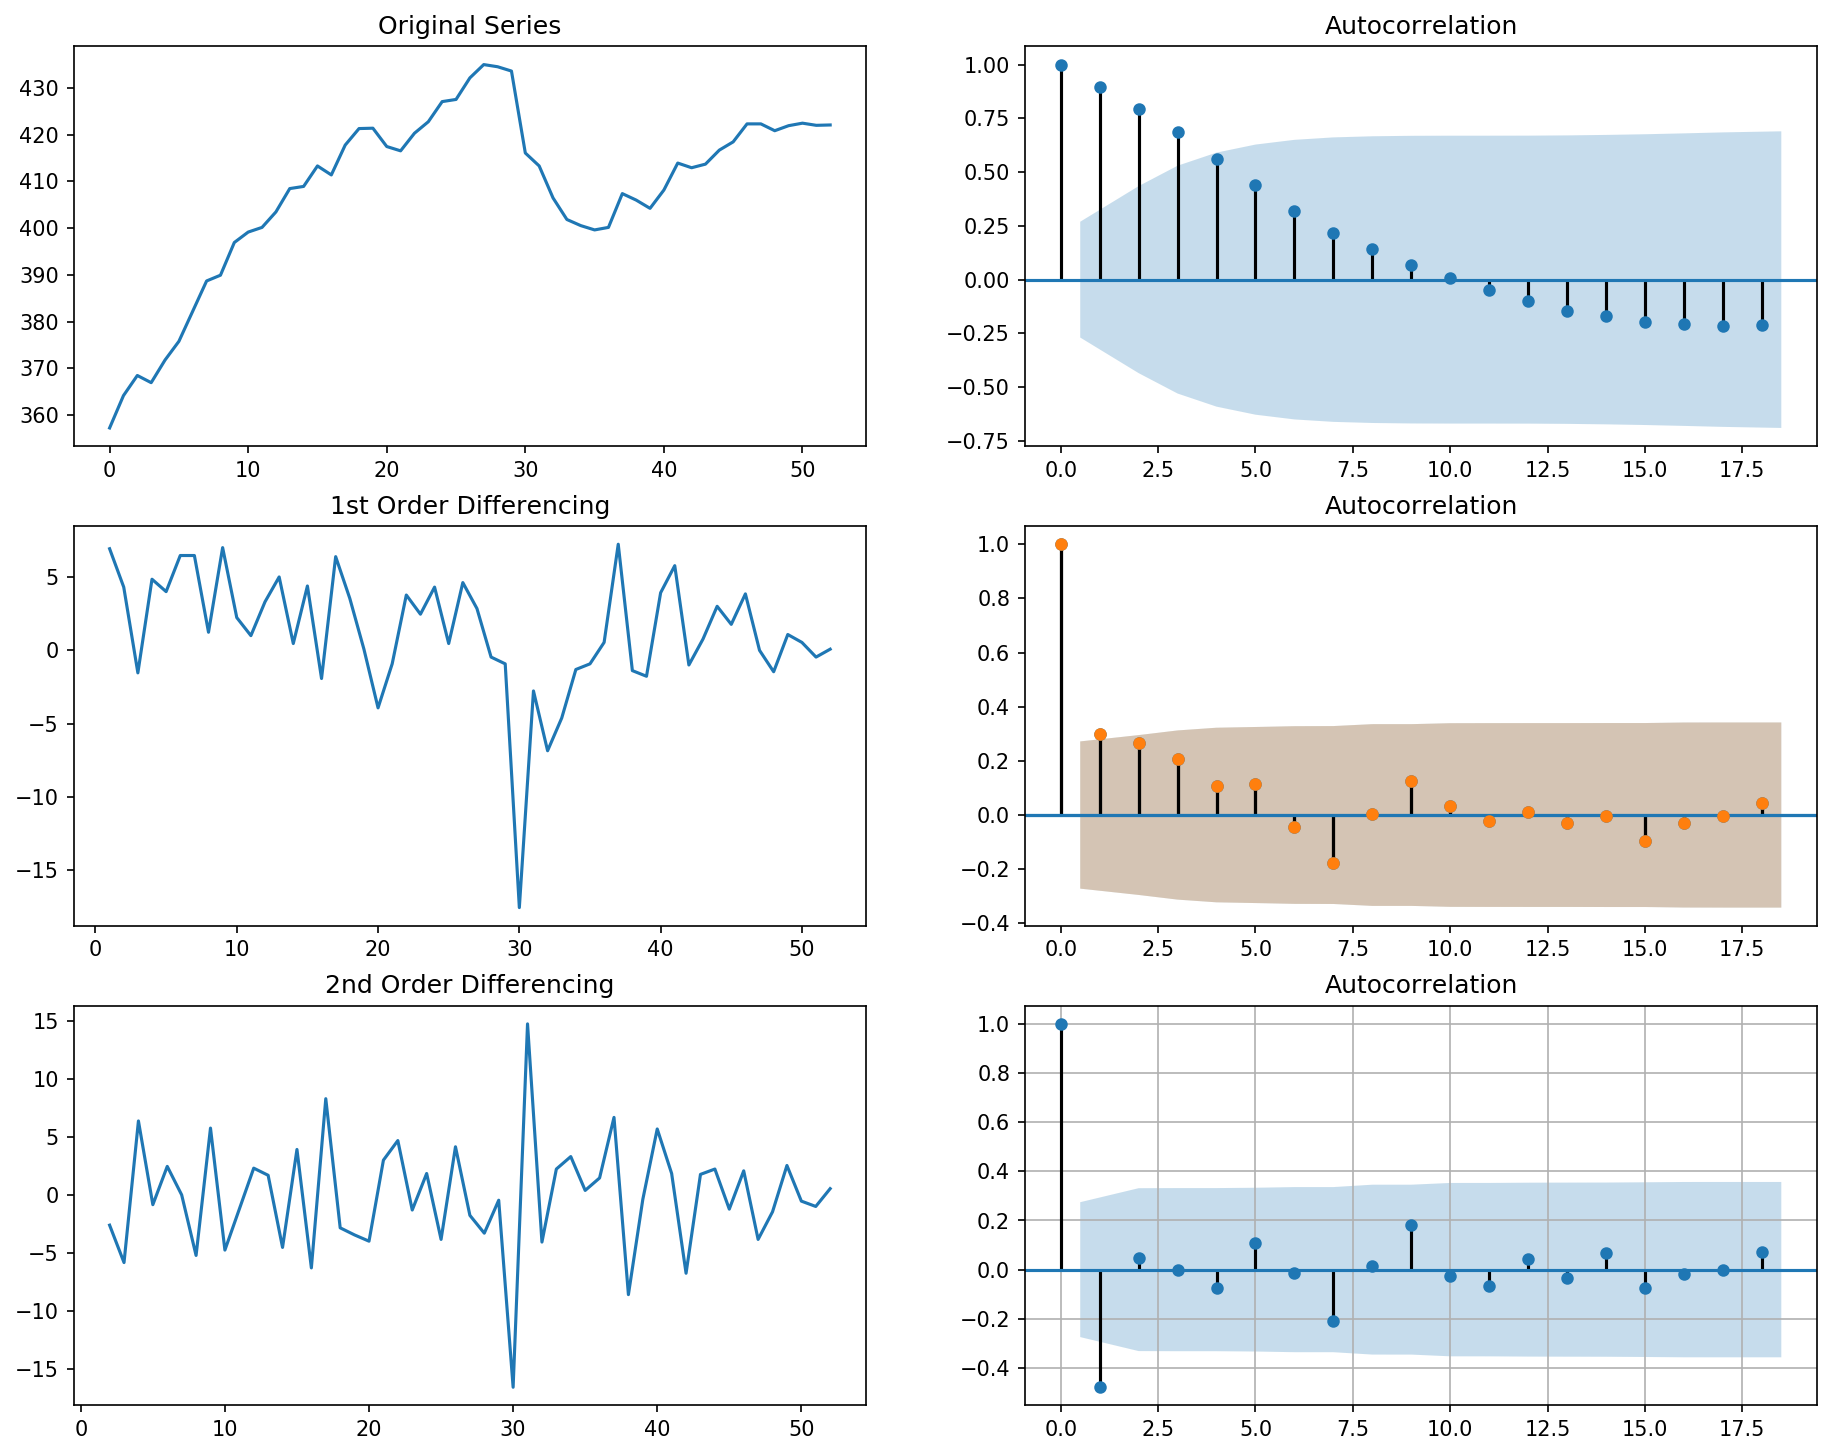

In [93]:
plot_acf(df1.y.diff().dropna(), ax=axes[1, 1])

#### Prepare dataset to apply ARIMA Model

In [94]:
df1.set_index('ds',inplace=True)

In [95]:
df1.head()

,y
ds,
1961-01-01,357.230769
1962-01-01,364.153846
1963-01-01,368.461538
1964-01-01,366.923077
1965-01-01,371.769231


In [96]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df1.y, order=(1,2,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   51
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -142.165
Method:                       css-mle   S.D. of innovations              3.819
Date:                Sat, 14 Dec 2019   AIC                            294.330
Time:                        16:34:31   BIC                            303.989
Sample:                    01-01-1963   HQIC                           298.021
                         - 01-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0864      0.060     -1.443      0.156      -0.204       0.031
ar.L1.D2.y     0.7117      0.231      3.086      0.003       0.260       1.164
ma.L1.D2.y    -1.4655      0.273     -5.373      0.0

### Try to improve the model
increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

### Create test train

In [97]:
train = df1.iloc[:39]
test=df1.iloc[38:,:]
fc, se, conf = model_fit.forecast(15, alpha=0.05) 

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   43
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -122.417
Method:                       css-mle   S.D. of innovations              4.160
Date:                Sat, 14 Dec 2019   AIC                            254.834
Time:                        16:34:41   BIC                            263.640
Sample:                    01-01-1962   HQIC                           258.081
                         - 01-01-2004                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4378      1.213      1.185      0.243      -0.940       3.816
ar.L1.D.y      0.4973      0.530      0.939      0.354      -0.541       1.536
ar.L2.D.y      0.1335      0.238      0.560      0.5

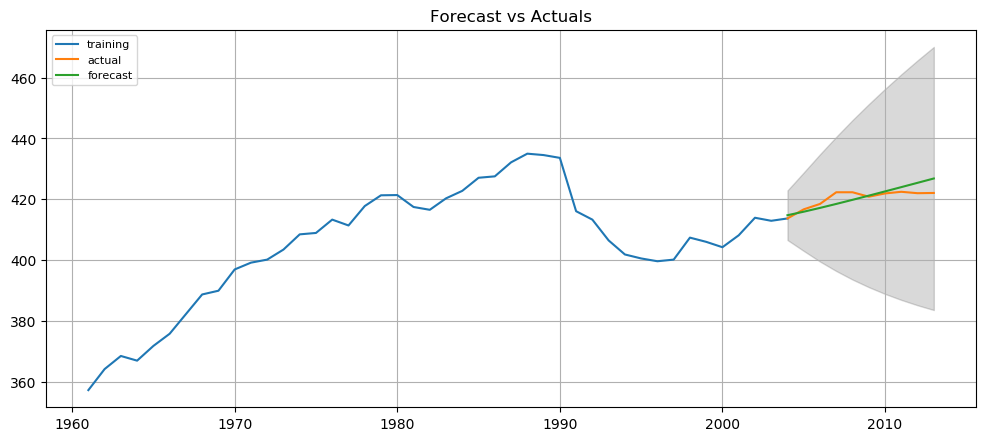

In [98]:
train = df1.iloc[:44]
test=df1.iloc[43:,:]

# Build Model
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

### Let's try the model ARIMA on the last 15 data points 

In [99]:
train.head()

,y
ds,
1961-01-01,357.230769
1962-01-01,364.153846
1963-01-01,368.461538
1964-01-01,366.923077
1965-01-01,371.769231


C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   38
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -108.752
Method:                       css-mle   S.D. of innovations              4.217
Date:                Sat, 14 Dec 2019   AIC                            227.504
Time:                        16:34:46   BIC                            235.692
Sample:                    01-01-1962   HQIC                           230.417
                         - 01-01-1999                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4970      1.379      1.086      0.285      -1.205       4.199
ar.L1.D.y      0.2633      0.430      0.612      0.545      -0.580       1.107
ar.L2.D.y      0.2808      0.211      1.333      0.1

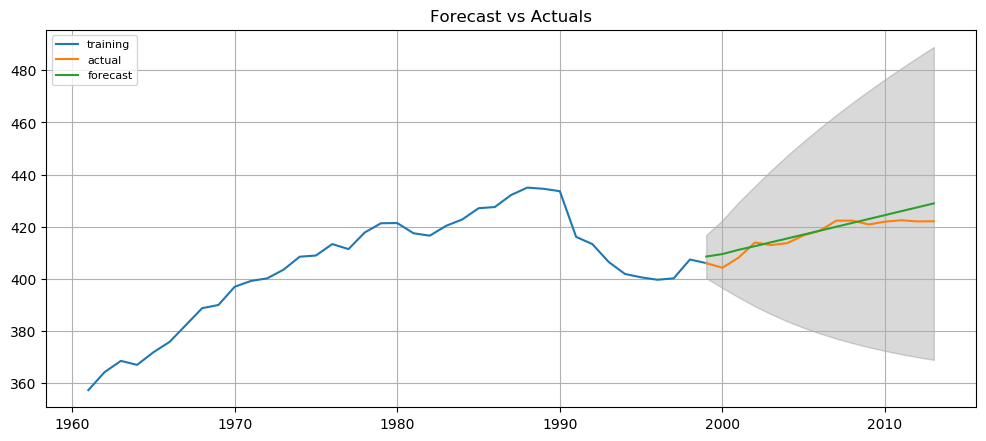

In [100]:
train = df1.iloc[:39]
test=df1.iloc[38:,:]

# Build Model
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

### Apply the model to predict

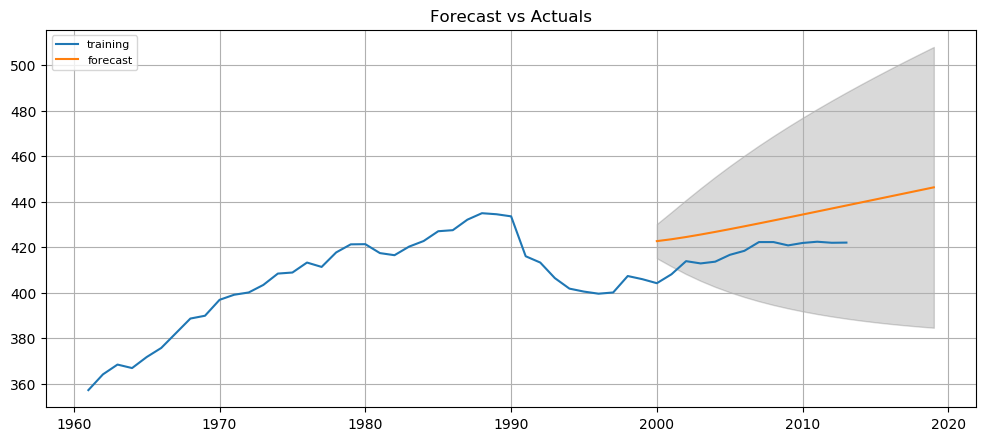

In [111]:
fc, se, conf = fitted.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=pd.date_range(train.tail(1).index[0], periods=20, freq='Y').tolist())
lower_series = pd.Series(conf[:, 0], index=pd.date_range(train.tail(1).index[0], periods=20, freq='Y').tolist())
upper_series = pd.Series(conf[:, 1], index=pd.date_range(train.tail(1).index[0], periods=20, freq='Y').tolist())

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df1, label='training')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.grid(True)
plt.show()

In [112]:
test.reset_index(inplace=True)

In [109]:
# Build Model
model = ARIMA(df1, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(10, alpha=0.05)  # 95% conf
fc
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   52
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -143.924
Method:                       css-mle   S.D. of innovations              3.846
Date:                Sat, 14 Dec 2019   AIC                            297.848
Time:                        16:37:06   BIC                            307.604
Sample:                    01-01-1962   HQIC                           301.588
                         - 01-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3333      1.026      1.299      0.200      -0.678       3.344
ar.L1.D.y      0.5369      0.465      1.156      0.254      -0.374       1.447
ar.L2.D.y      0.1141      0.214      0.534      0.5

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



ValueError: Length of passed values is 10, index implies 15

### Accuracy metrics

In [442]:
forecast=fc
actual=test.values

mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
me = np.mean(forecast - actual)             # ME
mae = np.mean(np.abs(forecast - actual))    # MAE
mpe = np.mean((forecast - actual)/actual)   # MPE
rmse = np.mean((forecast - actual)**2)**.5  # RMSE

In [443]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(fc, test.values)


{'mape': 0.009526187069161996,
 'me': 0.3370871249901256,
 'mae': 3.997360206930573,
 'mpe': 0.0008487924053665187,
 'rmse': 4.836646135086225}